# NB - Tiktok

In [1]:
import sys
import os
import pandas as pd

# Agregar el directorio raiz al PYTHONPATH
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

Importar modelo NB y cargar datos

In [2]:
from src.trainers.train_nb import train_nb
from src.trainers.utils import save_model
from src.trainers.utils import build_datasets, save_metrics
from constants.constants_tiktok import TIKTOK_DATASET_SENTENCES, TIKTOK_NB_METRICS_PATH

dataset_train, dataset_test, dataset_val = build_datasets(
    TIKTOK_DATASET_SENTENCES,
    test_size=0.3,
    val_size=0.5, # 0.5 de 0.3    
    random_state=42
)
print(dataset_train.shape)
print(dataset_test.shape)
print(dataset_val.shape)

(13727, 2)
(2942, 2)
(2942, 2)


## Hiperparámetros

In [3]:
import numpy as np

list_vectorizers = ["tfidf", "bow"]
list_alpha = np.logspace(-2, 1, 20)
print(list_alpha)

[ 0.01        0.0143845   0.02069138  0.02976351  0.04281332  0.06158482
  0.08858668  0.1274275   0.18329807  0.26366509  0.37926902  0.54555948
  0.78475997  1.12883789  1.62377674  2.33572147  3.35981829  4.83293024
  6.95192796 10.        ]


## Entrenar modelos

In [5]:
for vectorizer in list_vectorizers:
    for alpha in list_alpha:
        pipeline, metrics = train_nb(
            dataset_train,
            dataset_val,
            alpha=alpha,
            vec=vectorizer
        )
        print(f"NB {vectorizer} {alpha}: {metrics['accuracy']}")
        save_metrics(metrics, TIKTOK_NB_METRICS_PATH)

NB tfidf 0.01: 0.6240652617267165
NB tfidf 0.01438449888287663: 0.6271244051665533
NB tfidf 0.0206913808111479: 0.63256288239293
NB tfidf 0.029763514416313176: 0.6342624065261727
NB tfidf 0.04281332398719394: 0.636981645139361
NB tfidf 0.06158482110660264: 0.6417403127124405
NB tfidf 0.08858667904100823: 0.6464989802855201
NB tfidf 0.12742749857031335: 0.6512576478585996
NB tfidf 0.18329807108324356: 0.6553365057783821
NB tfidf 0.26366508987303583: 0.6560163154316792
NB tfidf 0.37926901907322497: 0.6621346023113528
NB tfidf 0.5455594781168517: 0.6638341264445955
NB tfidf 0.7847599703514611: 0.6662134602311353
NB tfidf 1.1288378916846884: 0.6706322229775663
NB tfidf 1.623776739188721: 0.6709721278042148
NB tfidf 2.3357214690901213: 0.6750509857239972
NB tfidf 3.359818286283781: 0.672331747110809
NB tfidf 4.832930238571752: 0.6682528891910265
NB tfidf 6.951927961775605: 0.6614547926580557
NB tfidf 10.0: 0.6587355540448674
NB bow 0.01: 0.6250849762066621
NB bow 0.01438449888287663: 0.6264

## Modelo con mayor accuracy

In [6]:
# Seleccionar los hiperparámetros que generan mayor accuracy
df_metrics = pd.read_csv(TIKTOK_NB_METRICS_PATH)

best_acc = df_metrics.loc[df_metrics['accuracy'].idxmax()]
print(best_acc)

accuracy      0.675051
recall        0.675067
precision     0.672705
f1_score       0.66483
model               NB
vectorizer       tfidf
alpha         2.335721
vocab_size        9046
train_time    0.133276
Name: 15, dtype: object


In [7]:
from constants.constants_tiktok import NB_PIPELINE_PATH

pipeline, metrics = train_nb(
    dataset_train,
    dataset_val,
    alpha=best_acc['alpha'],
    vec=best_acc['vectorizer'],
)

save_model(pipeline, NB_PIPELINE_PATH)

Modelo guardado en: c:\Users\Diego\Desktop\sentiment_analysis\models\tiktok\classifiers\nb_pipeline.pkl


Cargando modelo: c:\Users\Diego\Desktop\sentiment_analysis\models\tiktok\classifiers\nb_pipeline.pkl

Naive Bayes
Reporte de clasificacion
              precision    recall  f1-score   support

           0       0.70      0.66      0.68      1042
           1       0.45      0.64      0.53       693
           2       0.84      0.68      0.75      1207

    accuracy                           0.66      2942
   macro avg       0.66      0.66      0.65      2942
weighted avg       0.70      0.66      0.67      2942

Matriz de confusión


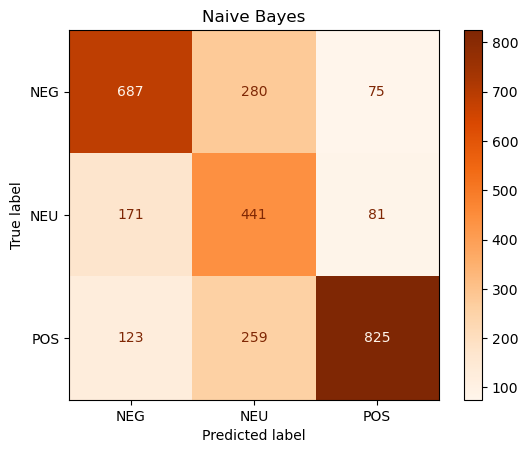

{'accuracy': 0.6638341264445955, 'recall': 0.6637614678899082, 'precision': 0.6597284997444337, 'f1_score': 0.6534997736762093}


In [8]:
from src.trainers.utils import evaluate_model
from src.trainers.utils import load_model

# Evaluar modelo con datos de prueba
pipeline = load_model(NB_PIPELINE_PATH)
metrics = evaluate_model(pipeline, dataset_test, title="Naive Bayes")
print(metrics)

## Test

In [9]:
from constants.constants_nlp import INDEX_TO_POLARITY
from src.preprocesamiento.clean import clean_text
from src.preprocesamiento.nlp_spacy import preprocesamiento

textos_test = ["Hola! cómo estás???😀","el dia de hoy estoy feliz y contento", "estoy muy triste", "Me encuentro estudiando para un exámen", "A veces me encuentro triste, pero la mayoria del tiempo estoy muy feliz"]
textos_test = list(map(lambda x: clean_text(x), textos_test))
textos_test = preprocesamiento(textos_test)

preds = pipeline.predict(textos_test)
for input, pred in zip(textos_test,preds):
    print(f"{input}: {INDEX_TO_POLARITY[pred]}")

Modelo cargado: es_core_news_sm


100%|██████████| 5/5 [00:00<?, ?it/s]
5it [00:00, 559.02it/s]

Aplicando stemming...
Total de documentos preprocesados: 5
hol estar: NEU
feliz content: POS
trist: NEG
encontr estudi exam: NEU
encontr trist mayor tiemp feliz: NEG
